In [12]:
import pandas as pd
import metrics
import numpy as np

In [13]:
metrics_dict = {
  # "NDCG@10 (↑)": metrics.calc_ndcg,
  # "Precision@5 (↑)": metrics.precision_at_k_class2,
  # "Recall@5 (↑)": metrics.recall_at_k_class2,
  "NRMSE (↓)": metrics.calc_nrmse,
  "NMAE (↓)": metrics.calc_nmae,
  "Cohen Kappa (↑)": metrics.calc_kappa,
  "Kendall Tau (↑)": metrics.calc_kendalltau,
  "RBO (↑)": metrics.calc_rbo
}
model_names = ["deepseek"]
prompt_names = ["true", "bing", "gemini", "grok", "gemini_fact", "grok_fact"]

# Промпты

* true – переведен оригинальный `TRUE`
* bing – переведенная структура оригинального `UMBRELLA`, но изменены критерии релевантности
* название модели – промнт сгенерирован LLM на основании мета-промпта `prompt_prompt`
* название модели + fact – промнт сгенерирован LLM на основании мета-промпта `prompt_prompt_fact`

Различия `prompt_prompt` и `prompt_prompt_fact`
* `prompt_prompt` – использует более общие критерии релевантности
* `prompt_prompt_fact` – критерии релевантности строго как описано в статье, именно подтверждение фактов

In [14]:
judgment_datas = {f"{model}_{prompt}": pd.read_csv(f"{model}_{prompt}.tsv", sep="\t") for model in model_names for prompt in prompt_names}

In [15]:
def gen_table():
  num_models = len(model_names)
  metric_names = list(metrics_dict.keys())
  multy_index = [
    [metric for metric in metric_names for _ in range(num_models)],
    [model for _ in range(len(metric_names)) for model in model_names]
  ]
  columns_num = len(multy_index[0])
  lines = []
  for prompt in prompt_names:
    prompt_res = np.zeros(num_models*len(metrics_dict), dtype=np.float64)
    for i in range(columns_num):
      model = multy_index[1][i]
      judgment_data = judgment_datas[f"{model}_{prompt}"]
      metric = multy_index[0][i]
      prompt_res[i] = metrics_dict[metric](judgment_data)
    lines.append(prompt_res)
  columns = pd.MultiIndex.from_arrays(multy_index, names=['Метрика', 'llm'])
  return pd.DataFrame(
    lines,
    columns=columns,
    index=prompt_names
  )
tb = gen_table()
tb.style.highlight_min(subset=['NRMSE (↓)', 'NMAE (↓)'], props='font-weight: bold').highlight_max(subset=['Cohen Kappa (↑)', 'Kendall Tau (↑)', 'RBO (↑)'], props='font-weight: bold')


Метрика,NRMSE (↓),NMAE (↓),Cohen Kappa (↑),Kendall Tau (↑),RBO (↑)
llm,deepseek,deepseek,deepseek,deepseek,deepseek
true,0.404370,0.323629,0.118452,0.048728,0.337883
bing,0.367905,0.269108,0.131905,0.048125,0.355211
gemini,0.366270,0.265106,0.141859,0.050878,0.353337
grok,0.393334,0.306823,0.139827,0.052725,0.351081
gemini_fact,0.379220,0.282613,0.145226,0.051948,0.355516
grok_fact,0.417396,0.340636,0.131106,0.052103,0.356950


# Пояснение

* NDCG поломанный так как 1. модель возвращает класс релевантности 0-2, 2. существенный дисбаланс классов релевантности в пользу 1 и вообще нет 0;
* Все остальные метрики очень низки;

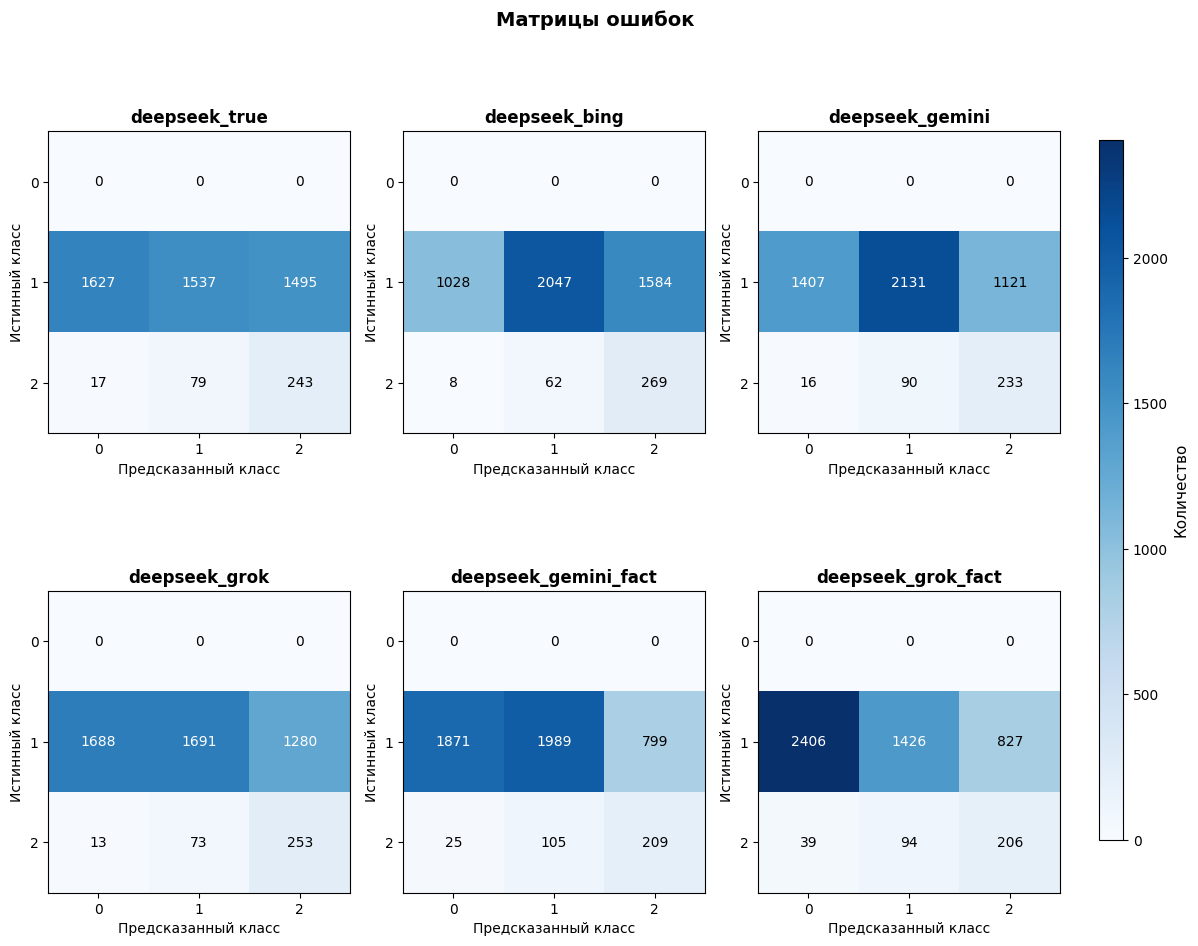

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
def plot_multiple_confusion_matrices(datasets: dict[str, any], num_classes=3, normalize=False):
    fig, axes = plt.subplots(2, 3, figsize=(12, 10))
    axes = axes.ravel()
    
    all_classes = [i for i in range(num_classes)]
    
    all_matrices = {}
    for data_name, data in datasets.items():
        llm = data["llm-score"].to_numpy(int)
        human = data["human-score"].to_numpy(int)
        cm_matrix = confusion_matrix(human, llm, labels=all_classes)
        
        if normalize:
            cm_matrix = cm_matrix.astype('float')
            row_sums = cm_matrix.sum(axis=1)[:, np.newaxis]
            row_sums[row_sums == 0] = 1
            cm_matrix = cm_matrix / row_sums
        
        all_matrices[data_name] = cm_matrix
    
    vmax = max([matrix.max() for matrix in all_matrices.values()])
    
    from matplotlib.cm import ScalarMappable
    from matplotlib.colors import Normalize
    norm = Normalize(vmin=0, vmax=vmax)
    
    for idx, (data_name, cm_matrix) in enumerate(all_matrices.items()):
        ax = axes[idx]
        
        im = ax.imshow(cm_matrix, cmap='Blues', norm=norm)
        
        for i in range(cm_matrix.shape[0]):
            for j in range(cm_matrix.shape[1]):
                text = f'{cm_matrix[i, j]:.2f}' if normalize else f'{int(cm_matrix[i, j])}'
                color = 'white' if cm_matrix[i, j] > vmax/2 else 'black'
                ax.text(j, i, text, ha='center', va='center', 
                       color=color, fontsize=10)
        
        ax.set_title(data_name, fontsize=12, fontweight='bold')
        ax.set_xticks(range(num_classes))
        ax.set_yticks(range(num_classes))
        ax.set_xticklabels(all_classes)
        ax.set_yticklabels(all_classes)
        
        ax.set_xlabel('Предсказанный класс', fontsize=10)
        ax.set_ylabel('Истинный класс', fontsize=10)
    
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    sm = ScalarMappable(norm=norm, cmap='Blues')
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label('Доля' if normalize else 'Количество', fontsize=11)
    
    fig.suptitle('Матрицы ошибок', fontsize=14, fontweight='bold')
    plt.show()

plot_multiple_confusion_matrices(judgment_datas, normalize=False)

# Пояснения

* Опять же виден перевес класса 1;
* Основная путаница между (1 и 0) и (1 и 2);
* Промпты fact более строги к ответам, больше всего ответов попадает в 0;

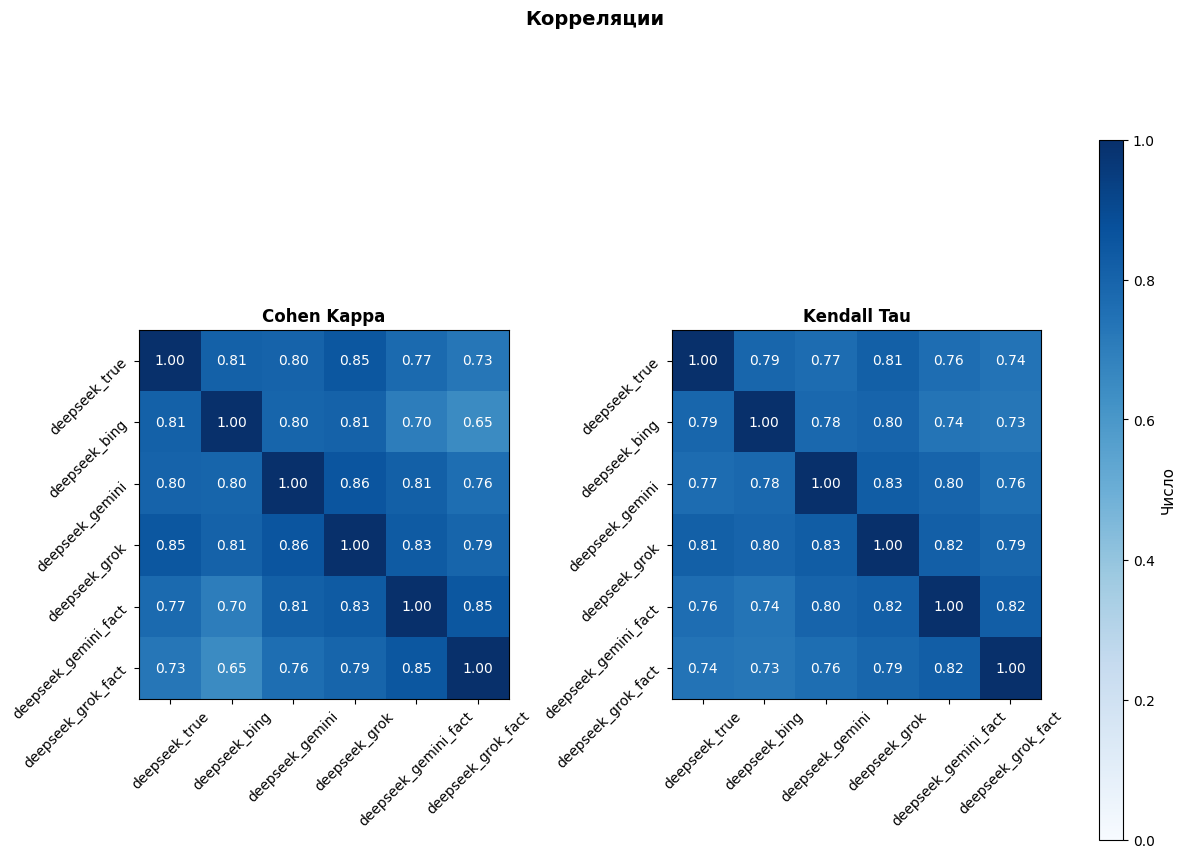

In [17]:
def plot_multiple_corr_matrices(datasets: dict[str, any], corr_metrics: dict[str:any], normalize=False):
    fig, axes = plt.subplots(1, 2, figsize=(12, 10))
    axes = axes.ravel()
    
    
    all_matrices = {}
    for metric_name, metric in corr_metrics.items():
      data = [data for _, data in datasets.items()]
      labels = [data_name for data_name, _ in datasets.items()]
      matrix = [[0 for _ in data] for _ in data]
      for i, data1 in enumerate(data):
          for j, data2 in enumerate(data):
              llm1 = data1["llm-score"].to_numpy(int)
              llm2 = data2["llm-score"].to_numpy(int)
              matrix[i][j] = metric(llm1, llm2)
      matrix = np.array(matrix)
      if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
        matrix = np.nan_to_num(matrix)
          
      all_matrices[metric_name] = (labels, matrix)
    
    vmax = max([matrix.max() for _, matrix in all_matrices.values()])
    
    from matplotlib.cm import ScalarMappable
    from matplotlib.colors import Normalize
    norm = Normalize(vmin=0, vmax=vmax)
    
    for idx, (data_name, (labels, matrix)) in enumerate(all_matrices.items()):
        ax = axes[idx]
        im = ax.imshow(matrix, cmap='Blues', norm=norm)
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                text = f'{matrix[i, j]:.2f}'
                color = 'white' if matrix[i, j] > vmax/2 else 'black'
                ax.text(j, i, text, ha='center', va='center', 
                       color=color, fontsize=10)
        
        ax.set_title(data_name, fontsize=12, fontweight='bold')
        ax.set_xticks(range(len(labels)))
        ax.set_yticks(range(len(labels)))
        ax.set_xticklabels(labels, rotation=45)
        ax.set_yticklabels(labels, rotation=45)
        
    
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    sm = ScalarMappable(norm=norm, cmap='Blues')
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label('Число', fontsize=11)
    
    fig.suptitle('Корреляции', fontsize=14, fontweight='bold')
    plt.show()
corr_metrics = {
    "Cohen Kappa": metrics.cohen_kappa_metric,
    "Kendall Tau": metrics.kendall_metric
}
plot_multiple_corr_matrices(judgment_datas, corr_metrics)

# Пояснения

* высокая корреляция между llm с разными промптами;
* ожидаемо корреляция чуть выше, когда промпты были сгенерированы при помощи одно и того же промпта;

# Самое интересное это прямое сравнение несоответствий оценок.

## Ситуация llm = 0 human = 2

LLM:  0 HUMAN:  2 ID:  16

Query:  "Самый модный скетинг-ринг (на илл.) в дореволюционном Санкт-Петербурге превратился в «дворец пьянствоблудия»."

Passage:  Американский скетинг-ринг множество раз оказывался в центре уголовной хроники. Сюда приходили взяточники. Один из самых главных скандалов был связан с «королевой скетинга» купеческой дочкой Марией Толстинской, постоянной посетительницей скетинг-ринга, которая влюбилась в молодого инструктора Альберта Грейчунаса.

Комментарий: В отрывке опоминается скетинг-ринг, но нету ни слова о Питере или цитаты «дворец пьянствоблудия». Это точно не 2.

LLM:  0 HUMAN:  2 ID:  36

Query:  "Создавая роман о Партенопейской республике, Александр Дюма мстил за отца."

Passage:  В первоначальном варианте Исаковского стихотворение называлось «В прифронтовом лесу» и имело посвящение его жене Лидии — Лиде. В том же виде, под тем же названием и с тем же посвящением, оно было воспроизведено в собрании сочинений Исаковского, изданном в конце 1960-х годов. Михаил Исаковский писал: «Стихи написаны на Каме, когда шёл второй год войны.

Комментарий: Вообще нет ни Дюма, ни мести за отца. Это точно 0.

LLM:  0 HUMAN:  2 ID:  56

Query:  "В известной советской военной песне использована мелодия вальса, который, вероятно, играли на борту тонущего «Титаника»."

Passage:  И чтобы стереть целую часть истории». Также Франкофор пришёл к выводу, что распространение вальса по всему миру связано с его популярностью в России и СССР. В Сербии вальс известен с текстом на национальном языке под названием «Осенние листья» (Jesenje lisce Архивная копия от 17 марта 2021 на Wayback Machine).

Комментарий: Говорится по каком то вальсе, нету ни Титаника ни военной песни. Это точно 0.

## Ситуация llm = 2 human = 1

LLM:  2 HUMAN:  1 ID:  93

Query:  Античный оратор пытался доказать, что он не доносчик и не святотатец.

Passage:  В 391 году до н. э. из-за превышения полномочий во время переговоров со Спартой о мире ему пришлось снова уйти в изгнание, и после этого он не упоминается в источниках. Защищая свою репутацию, страдавшую из-за обвинений в святотатстве и доносительстве, Андокид произнёс (в 407, 400/399 и 391 годах до н. э.) несколько речей, впоследствии изданных и принёсших автору посмертную славу. Андокид не был профессиональным оратором, а потому подвергался критике со стороны многих античных специалистов; но находились и ценители его простого и безыскусного стиля, благодаря которым тексты его произведений сохранились.

Комментарий: Полное подтверждение факта. Это точно 2.

LLM:  2 HUMAN:  1 ID:  116

Query:  В 2023 году мото-гран-при Португалии стал первым открытием календаря MotoGP в Европе с 2006 года и третьим за последние 30 лет.

Passage:  Из-за отсутствия возможности обеспечить социальное дистанцирование на трибунах, гонка прошла без зрителей. В 2023 году мото-гран-при Португалии открыл сезон чемпионата мира MotoGP. Этот этап стал первым открытием календаря MotoGP в Европе с 2006 года и третьим открытием сезона в Европе за последние три десятилетия.

Комментарий: Полное подтверждение факта. Это точно 2.

LLM:  2 HUMAN:  1 ID:  264

Query:  Киш на коронации Карла III (на илл.) показался «на удивление вкусным» многим, но член парламента — консерватор назвал его «отвратительным».

Passage:  Ранее Чарльз заявлял о своём пристрастии к блюдам из яиц, особенно к яичнице-болтунье. Критика Многие из приглашённых сочли киш «на удивление вкусным», дегустаторы оценили его в среднем на 9/10. Однако член парламента от консерваторов Джейкоб Рис-Могг назвал блюдо отвратительным.

Комментарий: Я не понимаю, что человеку не нравится. Это точно 2.

LLM:  2 HUMAN:  1 ID:  166

Query:  Витуберы (на илл.) — это ютуберы, скрывающие свою внешность за цифровыми аватарами.

Passage:  Архивировано 19 апреля 2020 года.. Виртуальный ютубер (яп. ハーチャルユーチューハー ба:тяру ю:тю:ба:, англ. Virtual YouTuber), или V-тубер (жарг. витубер, втубер; англ. VTuber, яп. フイチューハー) — создатель видеороликов (видеоблогер, стример), скрывающий свою внешность за цифровым аватаром — персонажем, созданным с помощью компьютерной графики и управляемым с помощью специальных программ для захвата движения (в отличие от других блогеров, использующих только веб-камеру). Данный тренд зародился в Японии в середине 2010-х годов, однако наибольшую популярность он приобрёл в начале 2020-х годов, став всемирным интернет-феноменом.

Комментарий: Я не понимаю, что человеку не нравится. Это точно 2.

LLM:  2 HUMAN:  1 ID:  246

Query:  Звучание инновационной драм-машины (на илл.) сравнивали с марширующими муравьедами.

Passage:  В одном из обзоров того времени звучание TR-808 было названо «марширующими муравьедами», хотя некоторые издания были более благосклонны, включая журнал Contemporary Keyboard, который предсказал, что TR-808 станет «стандартом для ритм-машин будущего». TR-808 потерпела неудачу с коммерческой точки зрения, было продано менее 12 000 единиц. Компания Roland прекратила производство модели в 1983 году.

Комментарий: драм-машины == ритм-машина. Это точно 2.

LLM:  2 HUMAN:  1 ID:  489

Query:  Судебный процесс между князем-аббатом (на илл.) и его соперником продолжался более четверти века.

Passage:  Однако его меры вызвали недовольство его протестантского окружения из знати и духовенства, которые в 1576 году отстранили его от власти в аббатстве и передали фактическую власть Юлиусу Эхтеру фон Меспельбрунну, который был князем-епископом Вюрцбурга. Сторонники Дернбаха обратились за помощью к императору Максимилиану II, который урегулировал судебный процесс, продлившийся 26 лет. В 1602 году Надворный совет вынес решение, восстановив Бальтазара в должности князя-аббата, а Меспельбрунн был вынужден отказаться от Фульды и заплатить судебные издержки.

Комментарий: Да, немного криво, но в целом. Это 2.


## Ситуация llm = 0 human = 1

LLM:  0 HUMAN:  1 ID:  364

Query:  Памятник архитектуры (на илл.) начала XIX века сначала разобрали для постройки входа в метро, а затем временно заменили «гнилым зубом».

Passage:  «Невский проспект» — станция Петербургского метрополитена. Расположена на Московско-Петроградской линии, между станциями «Сенная площадь» и «Горьковская». Станция открыта 1 июля 1963 года в составе участка «Технологический институт» — «Петроградская».

Комментарий: Общее это только питер и метро, вообще мимо сути. Это точно 0.

LLM:  0 HUMAN:  1 ID:  99

Query:  Баскетболистка сделала в женской НБА больше слэм-данков, чем вся остальная лига за свою историю.

Passage:  WNBA Enterprises, LLC. Дата обращения: 18 июня 2016.. Слэм-данк (англ. slam dunk; также dunk, dunk shot, jam, stuff, flush, throw down), бросок сверху — вид забивания в баскетболе (а также стритболе и слэмболе), при котором игрок выпрыгивает вверх и одной или двумя руками бросает мяч сквозь кольцо сверху вниз.

Комментарий: Где тут хоть какое-то подтверждение факта. Это точно 0.

LLM:  0 HUMAN:  1 ID:  435

Query:  Ради перехода в другой клуб испанский футболист однажды переоделся в женщину.

Passage:  Каждому из игроков команды было выплачено вознаграждение в размере 2 000 песет, что составляет менее 20 евро. Финансовое положение клуба было настолько тяжёлым, что даже эти скромные суммы были собраны из пожертвований. Должность тренера в это время занимал Иларио Марреро.

Комментарий: Абсолютно мимо. Это точно 0.

LLM:  0 HUMAN:  1 ID:  366

Query:  Паралимпийская и олимпийская сборные участвовали в играх в период войны за независимость своей страны.

Passage:  Война в Хорватии (март 1991 — ноябрь 1995) — военный конфликт на территории бывшей Социалистической Республики Хорватии, вызванный выходом Хорватии из состава Югославии. После объявления 25 июня 1991 года Хорватией независимости сербское население Хорватии пыталось создать своё государство на её территории, чтобы не выходить из состава Югославии. Хорватией это было расценено как попытка включения территорий Хорватии в состав Сербии.

Комментарий: Смешно. Это точно 0.

LLM:  0 HUMAN:  1 ID:  334

Query:  Несостоявшийся социолог занимался журналистикой, краеведением, фотографией и живописью.

Passage:  Применяется для изучения природных условий, геологического строения местности, животного и растительного мира, археологии и используется в процессе природоведческих и производственных экскурсий, походов и экспедиций. При организации полевых исследований разрабатывается программа, которая включает следующий круг вопросов: выбор объекта, цели и конкретные задачи исследования, формирование поисковых групп и распределение конкретных обязанностей между ними, предварительное ознакомление с территорией исследуемого участка, порядок и содержание поисковой работы на местности, научная обработка материалов, обобщение и оформление результатов работы. Визуальный метод
Визуальный метод — это непосредственное целенаправленное и планомерное наблюдение (обозрение), зарисовка, фотографирование или видеосъёмка изучаемых предметов и явлений (например, наблюдение за ростом растения или развитием птенцов в гнезде, изучение состава геологических пород).

Комментарий: Это к чему. Это точно 0.

Query:  Во время войны австралийские дети ходили в детский сад по радио.

Passage:  Ссылки Avatar.bz- online редактор для создания аватарок
Avatars в каталоге ссылок Curlie (dmoz)
AvaCreate.ru - создание аватарок online
АВАТАРИСТИКА — серия статей о психологическом толковании аватарок пользователей и предварительном построении логических цепей на основе этих толкований.. 3 сентября 1939 года, вскоре после вторжения немцев в Польшу, Австралия объявила Германии войну, тем самым вступив во Вторую мировую войну. В вооружённых силах страны в годы войны служило 993 тысячи человек из 6,9 млн человек населения страны.

Комментарий: Где связь. Это точно 0.


## Ситуация llm = 1 human = 2

LLM:  1 HUMAN:  2 ID:  54

Query:  Германо-скандинавский бог и его кабан особо почитались под Новый год.

Passage:  Жертва в виде кабана на Рождество сохранилась в виде традиции печь хлеб или пирог в виде кабана, что должно было помочь собрать большой урожай. Олаф Верелий в комментарии «Саги о Хёрвер» отмечал, что шведские крестьяне высушивали такой хлеб и хранили до весны. В это время года они мелко крошили его в сосуд, из которого будет вестись сев зерна.

Комментарий: Рождество != Новый год и Вообще нет никакого германо-скандинавского бога. Это точно 1.

Query:  Пираты и негры — это часть истории Абхазии

Passage:  Абхазские пираты — известный феномен в Средневековье, активно орудовавшие на территории Чёрного моря пираты из Абхазии. История Заря абхазского пиратства началась с образованием Абхазского княжества. В основном набеги абхазских пиратов были направлены к берегам Гурии, Мегрелии и Турции, но также проводились грабежи торговых кораблей даже в районах Крыма и Босфора.

Комментарий: Пираты есть, негров нет. Это точно 1.

LLM:  1 HUMAN:  2 ID:  40

Query:  Последний роман Джейн Остин пришлось дописывать сценаристам сериала.

Passage:  Первый сезон вышел на экраны в 2019 году, второй в 2022, третий — в 2023. Главные роли сыграли Роуз Уильямс, Тео Джеймс, Кейт Эшфилд, Кристал Кларк. Создатели сериала использовали сюжетный материал от Остин только в первых эпизодах, а в дальнейшем сами продолжили историю созданных писательницей персонажей.

Комментарий: Что значит пришлось? Нет формулировки последний роман. Спорно 1.

LLM:  1 HUMAN:  2 ID:  467

Query:  Семена растений можно взять в библиотеке.

Passage:  Ссылки Seed Science Research — международный журнал, посвящённый изучению семян (англ.) (Дата обращения: 29 января 2011). Библиотека семян (англ. Seed library) — учреждение, которое даёт взаймы или безвозмездно распространяет семена.

Комментарий: Тут да, LLM ошибся. Точно 2.

LLM:  1 HUMAN:  2 ID:  185

Query:  Гипотеза огнедышащих динозавров изучается в научной среде с 1977 года.

Passage:  Подходящие для аммиака окислители (жидкий кислород и жидкий фтор) имеют температуру кипения в −183º C и −188º C соответственно, что неприемлемо для живых организмов. Дополнительно встаёт проблема, что газообразные формы гипергольных смесей окутают голову динозавра, в случае применения газообразного и жидкого компонента газообразный компонент при взаимодействии со струёй жидкого компонента достигнет животного, а применение только жидких компонентов для безопасности самого животного требует их соединения на достаточно большом расстоянии от динозавра. Возможные органы для извержения огня Некоторые авторы (Gish в 1977 году, Petersen в 1986 году, Morris в 1988 году, Niermann в 1994 году, DeYoung в 2000 году, Petersen в 2002 году) предполагают, что полые гребни утконосых динозавров подсемейства ламбеозаврин (например, коритозавра) были предназначены для хранения или смешивания горючих газов.

Комментарий: Спорно, но я считаю с 1977 года предполагает наличия слова впервые. Скорее 1.

LLM:  1 HUMAN:  2 ID:  36

Query:  "Создавая роман о Партенопейской республике, Александр Дюма мстил за отца."

Passage:  После того, как об этих событиях стало известно в Великобритании, Чарльз Джеймс Фокс осудил Нельсона в Палате общин за участие адмирала в «зверствах в Неаполитанском заливе». В культуре Об истории Партенопейской республики рассказывает Александр Дюма-отец в романе «Луиза Сан-Феличе», который был несколько раз экранизирован. На основе романа была написана одноимённая пьеса.

Комментарий: Тут хотя бы упоминается отец, но это точно не 2. Это точно 1.

In [18]:
all_dfs = [data for data in judgment_datas.values()]

masks = []
for df in all_dfs:
    mask = (df['llm-score'] == 1) & (df['human-score'] == 2)
    masks.append(mask)

combined_mask = masks[0]
for mask in masks[1:]:
    combined_mask = combined_mask & mask

res = all_dfs[0][combined_mask]
# res = judgment_datas["gemma3:4b_bing"]
corpus = pd.read_json("corpus.jsonl", lines=True)
queries = pd.read_json("queries.jsonl", lines=True)
corpus.set_index("_id", inplace=True)
queries.set_index("_id", inplace=True)
# for _, row in res.sample(10).iterrows():
#   print("LLM: ", row["llm-score"], "HUMAN: ", row["human-score"], "ID: ", row["query-id"])
#   print("Query: ", queries.loc[row["query-id"]]["text"])
#   print("Passage: ", corpus.loc[row["corpus-id"]]["text"])

# Вывод

Проведенный анализ выявил не просто расхождение в критериях оценки между LLM и человеческими аннотаторами, а фундаментальную неконсистентность человеческой разметки. Наблюдаются систематические ошибки трех типов: неоправданная либеральность (приписывание релевантности на основе тематического сходства), избыточная строгость (требование дословного соответствия) и полная логическая несогласованность.

В таких условиях использование человеческих оценок в качестве ground truth теряет валидность. Единственный содержательный вывод из проведенных экспериментов — высокая корреляция между различными LLM промптами (0.70-0.85), что свидетельствует о внутренней согласованности моделей при оценке релевантности.

Таким образом, более перспективным направлением представляется исследование взаимного согласия LLM и разработка метрик, основанных на консенсусе искусственных моделей, а не на проблематичных человеческих аннотациях.